In [1]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
from deepxde.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


## Half Circle Equation

Length Domain : $[0, \pi r]$

From equation of circle
$(x-u)^2+(y-v)^2=a^2$

Implicit differentiaion:
$x'(x-u)+y'(y-v)=0$

IC: $x(0)=u+a, \quad y(0)=v$

PDE: $x'=-y+v, \quad y' = x-u$

In [2]:
# constants
r = 1


In [3]:
def pde(s,y):
    
    x_s = y[:,0:1] 
    dx_ds = dde.grad.jacobian(x_s, s)
    y_s = y[:,1:2]
    dy_ds = dde.grad.jacobian(y_s, s)
    
    return dx_ds + y_s, dy_ds - x_s

geom = dde.geometry.Interval(0, np.pi)

def start_bound(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def end_bound(x, on_boundary):
    return on_boundary and np.isclose(x[0], np.pi)

def func(s):
    return np.cos(s), np.sin(s)

x_start = dde.DirichletBC(geom, lambda x: 0, start_bound, component=0)
y_start = dde.DirichletBC(geom, lambda x: -1, start_bound, component=1)
x_end = dde.DirichletBC(geom, lambda x:  0, end_bound, component=0)
y_end = dde.DirichletBC(geom, lambda x: 1, end_bound, component=1)

data = dde.data.PDE(
    geom,
    pde,
    [x_start, y_start, x_end, y_end],
    num_domain=100,
    num_boundary=30,
    train_distribution='uniform'
)

layer_size = [1] + [20] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)
# net.outputs_modify(lambda x, y: x * y)

model = dde.Model(data, net)

model.compile("adam", lr=0.001)
# movie = dde.callbacks.MovieDumper(
#     "movie_demo_circle", [0], [1], period=100, save_spectrum=True, y_reference=func
# )
losshistory, train_state = model.train(epochs=5000)




Compiling model...
Building feed-forward neural network...
'build' took 0.079044 s



/home/syamil/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/syamil/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 2.532939 s

Initializing variables...
Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.65e-01, 4.36e-01, 0.00e+00, 1.00e+00, 4.69e-01, 2.91e-01]    [1.65e-01, 4.36e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [5.28e-04, 3.55e-03, 2.62e-05, 1.00e-07, 2.97e-05, 4.58e-05]    [5.28e-04, 3.55e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2000      [1.72e-04, 1.26e-04, 1.17e-07, 7.78e-11, 2.45e-07, 1.53e-07]    [1.72e-04, 1.26e-04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
3000      [4.77e-05, 1.02e-04, 7.39e-08, 4.41e-09, 1.29e-07, 1.03e-07]    [4.77e-05, 1.02e-04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
4000      [2.82e-05, 7.53e-05, 3.25e-08, 1.22e-07, 9.48e-06, 8.40e-06]    [2.82e-05, 7.53e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
5000      [1.23e-05, 5.24e-05, 3.04e-08, 7.52e-10, 9.07e-08, 1.

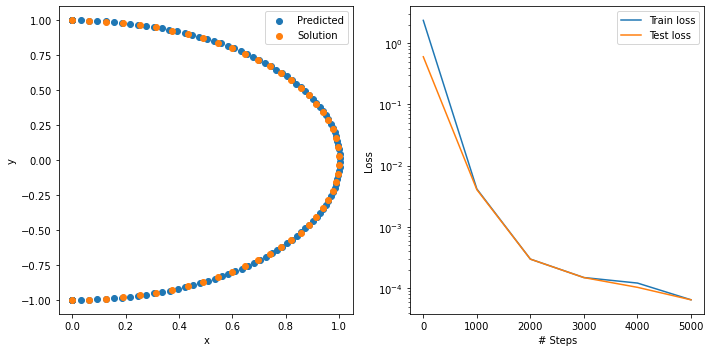

In [5]:
X_train, y_train, X_test, y_test, best_y, best_ystd = train_state.packed_data()
z = func(np.linspace(np.pi/2,-np.pi/2))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax[0].scatter(best_y.T[0], best_y.T[1], label='Predicted')
ax[0].scatter(z[0], z[1], label='Solution')
ax[0].set_ylabel("y")
ax[0].set_xlabel("x")
ax[0].legend()

loss_train = np.sum(losshistory.loss_train, axis=1)
loss_test = np.sum(losshistory.loss_test, axis=1)

ax[1].semilogy(losshistory.steps, loss_train, label="Train loss")
ax[1].semilogy(losshistory.steps, loss_test, label="Test loss")
for i in range(len(losshistory.metrics_test[0])):
    ax[1].semilogy(
        losshistory.steps,
        np.array(losshistory.metrics_test)[:, i],
        label="Test metric",
    )
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("# Steps")
ax[1].legend()

fig.tight_layout()